In [1]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
from typing import Dict

from womad_feedback.regions import RegionExtractor, _gscale


In [2]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def image_path(session_id, image_id):
    return data_path / session_id / "40 - align" / f"{image_id}.png"

def read_image_and_metadata(image_path):
    image = read_image(image_path)

    image_metadata_path = image_path.with_suffix(".json")
    image_metadata_path = image_metadata_path.parent.parent / "10 - locations" / image_metadata_path.name
    image_metadata = json.loads(image_metadata_path.read_text())

    return image, image_metadata

def plot_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    plt.show()

data_path = Path("./input/womad - 2024/analysis")
assets_path = data_path / "assets"




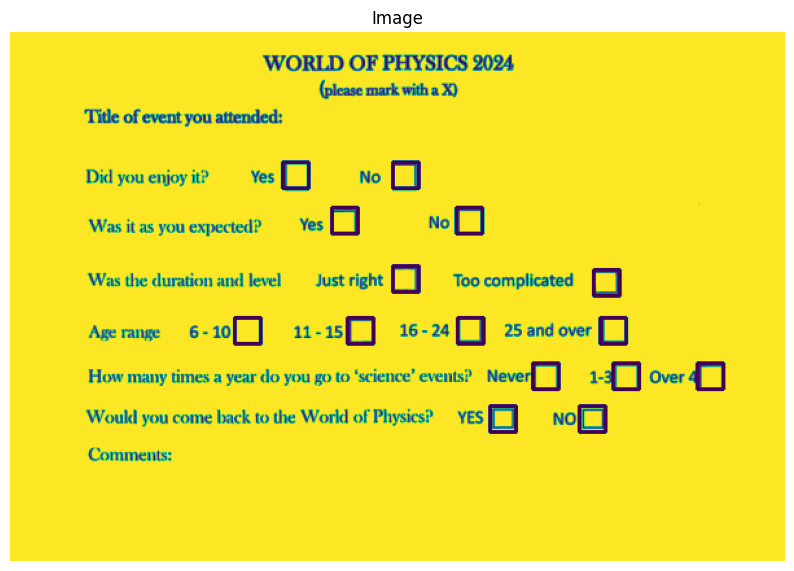

In [3]:
extractor = RegionExtractor(mask_size=3)
template = extractor.markup_image_regions("2024", boundary_size=10)
plot_image(template)

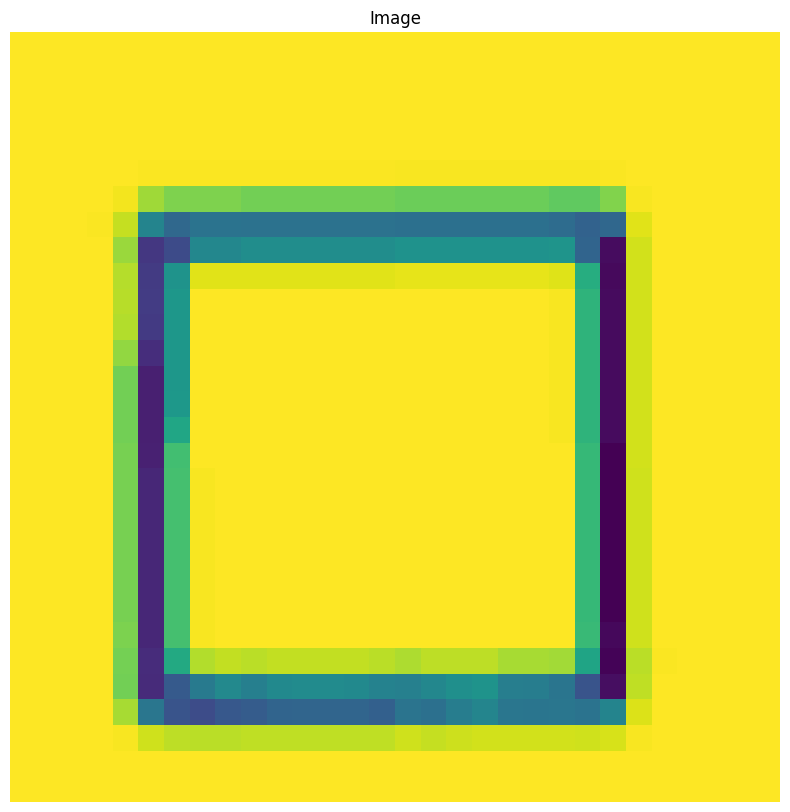

In [4]:
my_image_path = image_path("000", "016")
my_image = _gscale(my_image_path)

image_regions = extractor.get_image_regions(my_image, "2024")
plot_image(image_regions['2024_q2_True'])

2024_q1_True 7709.0803501828395  - TICKED


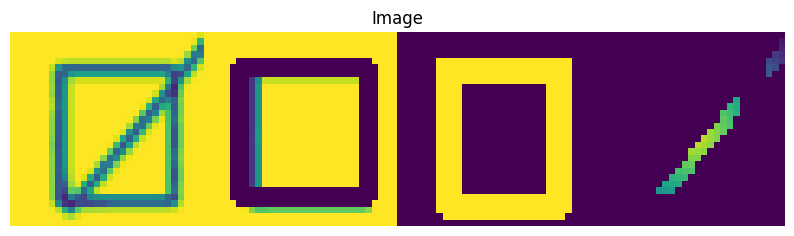

2024_q1_False 0.0 


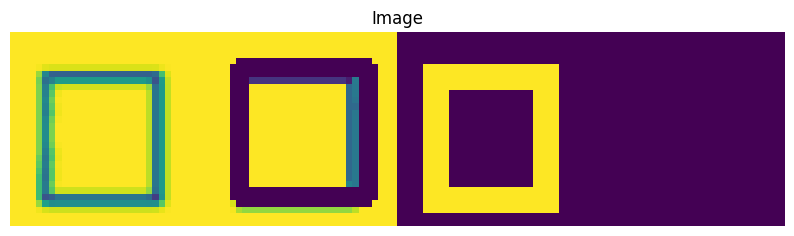

2024_q2_True 8353.2483809483  - TICKED


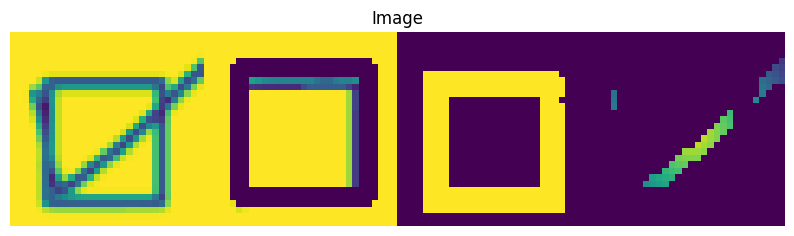

2024_q2_False 141.99530140071636 


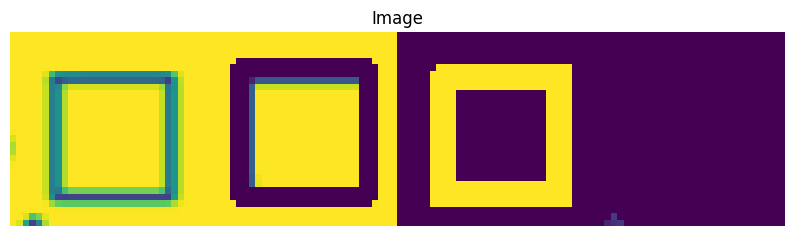

2024_q3_Just right 10050.719950770304  - TICKED


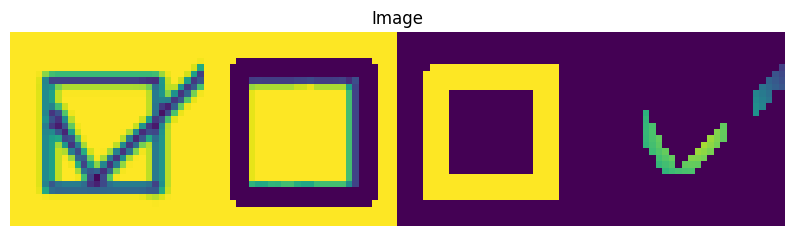

2024_q3_Too complicated 0.0 


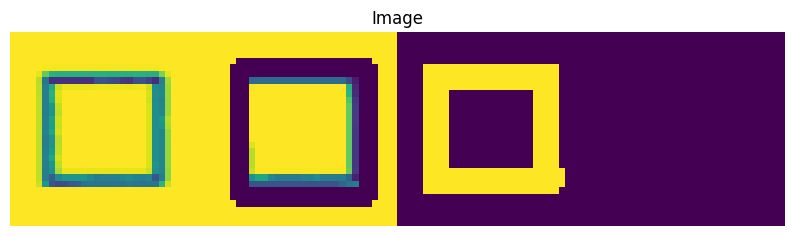

2024_q4_6 - 10 12058.920449138139  - TICKED


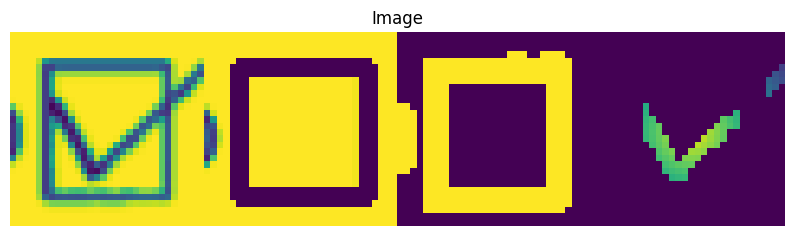

2024_q4_11 - 15 0.0 


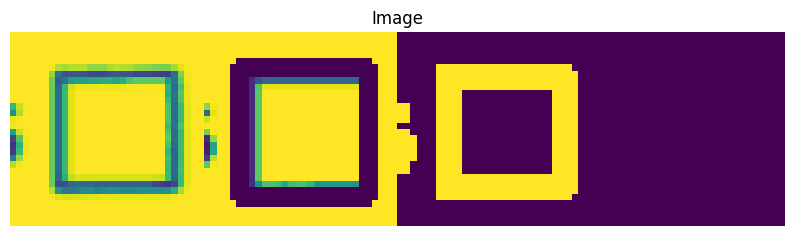

2024_q4_16 - 24 0.0 


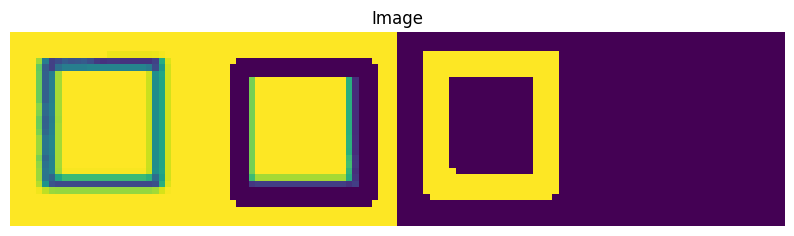

2024_q4_25 and over 0.0 


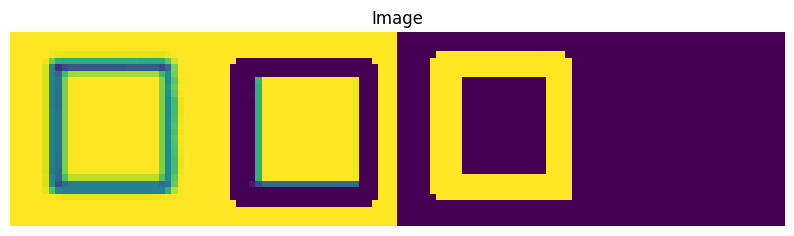

2024_q5_Never 1013.7200612092697 


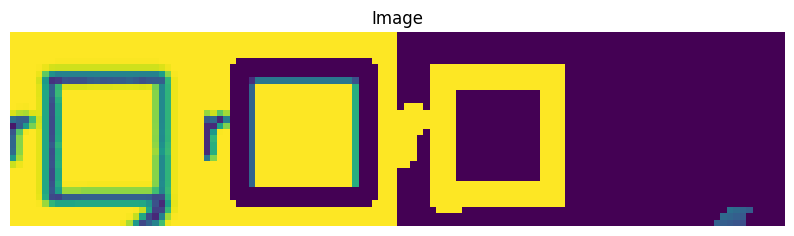

2024_q5_1 - 3 11895.551473465053  - TICKED


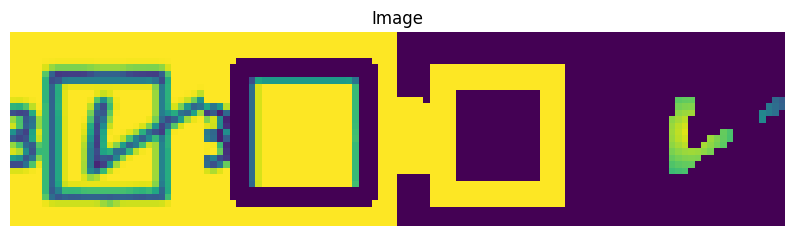

2024_q5_Over 4 0.0 


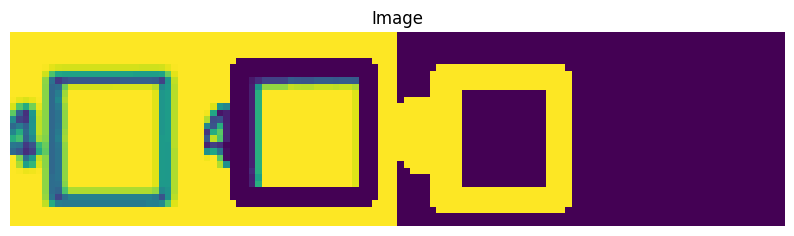

2024_q6_True 3851.369476135752 


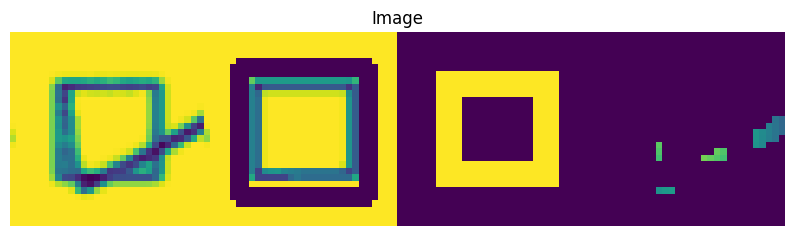

2024_q6_False 0.0 


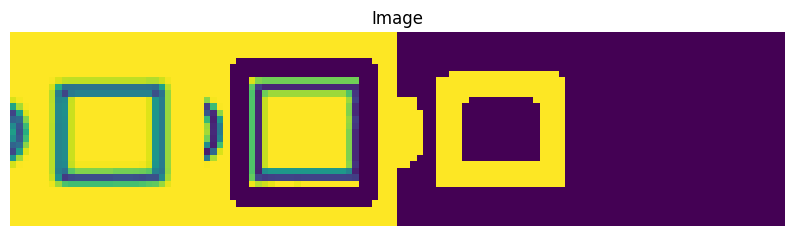

In [5]:
my_image_path = image_path("000", "013")
regions = extractor.extract_regions(my_image_path, "2024", align=False)
weight_threshold=4_000
for region_name, (aligned_image, weight) in regions.items():
    ticked = " - TICKED" if weight > weight_threshold else ""
    print(region_name, weight, ticked)
    plot_image(aligned_image)


In [67]:
import pandas as pd

index = pd.read_csv(data_path / "$$$ - identify" / "index.csv")
schedule = pd.read_csv(data_path / "$$$ - identify" / "schedule.csv")

In [68]:
def get_event_data(session_id):
    session_data = index[index.session == int(session_id)].to_dict(orient='records')[0]
    slot = session_data['slot']
    try:
        schedule_data = schedule[schedule.Name == slot].to_dict(orient='records')[0]
    except:
        print("No data found for slot", slot)
        schedule_data = {}
    return  {**session_data, **schedule_data }


In [70]:
for session_path in sorted(data_path.glob("0??")):
    source_path = session_path / "00 - source images"
    target_path = session_path / "50 - extract"
    target_path.mkdir(exist_ok=True, parents=True)

    

    session_data = {
        "cover_image": None,
        "forms": [],
        "event_data": get_event_data(session_path.name)
    }

    for ix, target_image_path in enumerate(sorted(source_path.glob("???.png"))):
        my_image_path = image_path(session_path.name, target_image_path.stem)
        image, md = read_image_and_metadata(my_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ticked_regions = []

        feedback_sheet = "stars" in md
        if feedback_sheet:
            form_data = {
                "form_seq": len(session_data['forms']) + 1,
                "form_image": target_image_path.name
            }
            session_data['forms'].append(form_data)
            regions = extractor.extract_regions(my_image_path, "2024", align=False)
            weight_threshold=3_500
            for region_name, (aligned_image, weight) in regions.items():
                ticked = weight > weight_threshold
                if ticked:
                    ticked_regions.append(region_name)

            form_data['ticked'] = ticked_regions
        elif len(session_data['forms']) == 0:
            session_data['cover_image'] = target_image_path.name
        else:
            form_data = session_data['forms'][-1]
            form_data['comments_image'] = target_image_path.name

        print(session_path.name, target_image_path.stem, ticked_regions)
        for region_name in ticked_regions:
            region = extractor.get_answer_defintion(region_name)
            image = cv2.circle(image, region['pos'], 10, (0, 0, 255), 2)

        cv2.imwrite(target_path / my_image_path.name, image)

    (target_path / "data.json").write_text(json.dumps(session_data, indent=2))
    




000 001 []
000 002 ['2024_q1_True', '2024_q2_True', '2024_q3_Just right', '2024_q4_6 - 10', '2024_q4_11 - 15', '2024_q5_1 - 3', '2024_q6_True']
000 003 ['2024_q1_True', '2024_q2_True', '2024_q3_Just right', '2024_q4_6 - 10', '2024_q5_1 - 3', '2024_q6_True']
000 004 ['2024_q1_True', '2024_q2_True', '2024_q3_Just right', '2024_q4_6 - 10', '2024_q5_Over 4', '2024_q6_True']
000 005 ['2024_q1_True', '2024_q2_True', '2024_q3_Just right', '2024_q4_6 - 10', '2024_q5_1 - 3', '2024_q6_True']
000 006 ['2024_q1_True', '2024_q2_True', '2024_q3_Just right', '2024_q4_25 and over', '2024_q5_1 - 3', '2024_q6_True']
000 007 ['2024_q1_True', '2024_q2_False', '2024_q3_Just right', '2024_q4_6 - 10', '2024_q5_Over 4', '2024_q6_True']
000 008 ['2024_q1_True', '2024_q2_False', '2024_q3_Just right', '2024_q4_6 - 10', '2024_q5_1 - 3', '2024_q6_True']
000 009 ['2024_q1_True', '2024_q2_True', '2024_q3_Just right', '2024_q4_6 - 10', '2024_q5_1 - 3', '2024_q6_True']
000 010 ['2024_q1_True', '2024_q2_True', '2024_q3

In [71]:
all_qs = []
t = 2024
for q, q_def in extractor.defintions[t].items():
    question = q_def['question']
    for b, b_def in q_def['boxes'].items():
        id = f"{t}_{q}_{b}"
        all_qs.append((id, question, b_def['answer']))

all_qs


[('2024_q1_True', 'Did you enjoy it?', True),
 ('2024_q1_False', 'Did you enjoy it?', False),
 ('2024_q2_True', 'Was it as you expected?', True),
 ('2024_q2_False', 'Was it as you expected?', False),
 ('2024_q3_Just right', 'Was the duration and Level', 'Right'),
 ('2024_q3_Too complicated', 'Was the duration and Level', 'Complicated'),
 ('2024_q4_6 - 10', 'Age range', '6 - 10'),
 ('2024_q4_11 - 15', 'Age range', '11 - 15'),
 ('2024_q4_16 - 24', 'Age range', '16 - 24'),
 ('2024_q4_25 and over', 'Age range', '25 and over'),
 ('2024_q5_Never', 'How many times a year to go to science events?', 'Never'),
 ('2024_q5_1 - 3', 'How many times a year to go to science events?', '1 - 3'),
 ('2024_q5_Over 4',
  'How many times a year to go to science events?',
  'Over 4'),
 ('2024_q6_True', 'Would you come back?', True),
 ('2024_q6_False', 'Would you come back?', False)]

In [87]:
all_data = []

ticked_columns = {q[0]: 0 for q in all_qs}
rename_columns = {
    q[0]: (q[1], q[2]) for q in all_qs
}


for session_path in sorted(data_path.glob("0??")):
    source_path = session_path / "50 - extract"
    session_data = json.loads((source_path / "data.json").read_text())

    event_data = session_data.get("event_data")
    if event_data:
        event_data = {
            "session_id": session_path.name,
            "slot": event_data["slot"],
            "title": event_data.get("Events"),
            "day": event_data.get("Day"),
            "time": event_data.get("Time"),
            "performers": event_data.get("Performer(s) (from Events)"),
        }
    else:
        event_data = {
            "session_id": session_path.name
        }


    for form in session_data['forms']:
        ticked = ticked_columns.copy()
        for v in form["ticked"]:
            ticked[v] = 1

        form_data = {
            **event_data,
            **ticked
        }
        all_data.append(form_data)


all_data = pd.DataFrame(all_data)
all_data.rename(columns=rename_columns, inplace=True)
all_data.columns = pd.MultiIndex.from_tuples([(col, '') if not isinstance(col, tuple) else col for col in all_data.columns])


all_data

session_id      slot                title  day   time  \
                                                            
0          000     FR-12  The MAKERS Workshop  Fri  12:00   
1          000     FR-12  The MAKERS Workshop  Fri  12:00   
2          000     FR-12  The MAKERS Workshop  Fri  12:00   
3          000     FR-12  The MAKERS Workshop  Fri  12:00   
4          000     FR-12  The MAKERS Workshop  Fri  12:00   
..         ...       ...                  ...  ...    ...   
843        033  FR-14-DZ     The MAKERS Space  Fri  14:00   
844        033  FR-14-DZ     The MAKERS Space  Fri  14:00   
845        033  FR-14-DZ     The MAKERS Space  Fri  14:00   
846        033  FR-14-DZ     The MAKERS Space  Fri  14:00   
847        033  FR-14-DZ     The MAKERS Space  Fri  14:00   

                           performers Did you enjoy it?        \
                                                   True False   
0    Laura Fogg-Rogers,Steve Regester                 1     0   
1    Laura Fogg-Rogers,Steve Regester                 1     0   
2    Laura Fogg-Rogers,Steve Regester                 1     0   
3    Laura Fogg-Rogers,Steve Regester                 1     0   
4    Laura Fogg-Rogers,Steve Regester                 1     0   
..                                ...               ...   ...   
843  Laura Fogg-Rogers,Steve Regester                 0     0   
844  Laura Fogg-Rogers,Steve Regester                 0     0   
845  Laura Fogg-Rogers,Steve Regester                 1     0   
846  Laura Fogg-Rogers,Steve Regester                 1     0   
847  Laura Fogg-Rogers,Steve Regester                 1     0   

    Was it as you expected?        ... Was the duration and Level Age range  \
                       True False  ...                Complicated    6 - 10   
0                         1     0  ...                          0         1   
1                         1     0  ...                          0         1   
2                         1     0  ...                          0         1   
3                         1     0  ...                          0         1   
4                         1     0  ...                          0         0   
..                      ...   ...  ...                        ...       ...   
843                       0     0  ...                          0         0   
844                       0     0  ...                          0         0   
845                       1     0  ...                          0         1   
846                       1     0  ...                          0         1   
847                       1     0  ...                          0         0   

                                 \
    11 - 15 16 - 24 25 and over   
0         1       0           0   
1         0       0           0   
2         0       0           0   
3         0       0           0   
4         0       0           1   
..      ...     ...         ...   
843       0       0           0   
844       0       0           0   
845       0       0           0   
846       0       0           0   
847       0       0           1   

    How many times a year to go to science events?               \
                                             Never 1 - 3 Over 4   
0                                                0     1      0   
1                                                0     1      0   
2                                                0     0      1   
3                                                0     1      0   
4                                                0     1      0   
..                                             ...   ...    ...   
843                                              0     0      0   
844                                              0     0      0   
845                                              0     1      0   
846                                              0     1      0   
847                                              0     0      1   

    Woul

## Analysis View

Create a view that's better for analysis

In [90]:
def determine_group_response(row):
    non_zero_columns = row[row != 0]
    if len(non_zero_columns) == 0:
        return "-"
    elif len(non_zero_columns) == 1:
        return non_zero_columns.index[0][1]
    else:
        return "+"
    
def summarise_columns(level_name):
    column_group = all_data.loc[:, all_data.columns.get_level_values(0) == level_name]
    all_data[("Summary", level_name)] = column_group.apply(determine_group_response, axis=1)

for q in all_qs:
    summarise_columns(q[1])

all_data.to_excel(data_path / "all-forms.xlsx")
all_data

In [97]:
simple = all_data.copy()
answer_cols = [q[1] for q in all_qs]
columns_to_drop = simple.columns.get_level_values(0).isin(answer_cols)
simple = simple.loc[:, ~columns_to_drop]
simple.columns = [
    c[1] if c[0] == "Summary" else c[0] for c in simple.columns
]
simple.to_excel(data_path / "all-forms-simple.xlsx", index=False)
simple

,session_id,slot,title,day,time,performers,Age range,Did you enjoy it?,Was it as you expected?,Was the duration and Level,How many times a year to go to science events?,Would you come back?
0,000,FR-12,The MAKERS Workshop,Fri,12:00,"Laura Fogg-Rogers,Steve Regester",+,True,True,Right,1 - 3,True
1,000,FR-12,The MAKERS Workshop,Fri,12:00,"Laura Fogg-Rogers,Steve Regester",6 - 10,True,True,Right,1 - 3,True
2,000,FR-12,The MAKERS Workshop,Fri,12:00,"Laura Fogg-Rogers,Steve Regester",6 - 10,True,True,Right,Over 4,True
3,000,FR-12,The MAKERS Workshop,Fri,12:00,"Laura Fogg-Rogers,Steve Regester",6 - 10,True,True,Right,1 - 3,True
4,000,FR-12,The MAKERS Workshop,Fri,12:00,"Laura Fogg-Rogers,Steve Regester",25 and over,True,True,Right,1 - 3,True
...,...,...,...,...,...,...,...,...,...,...,...,...
843,033,FR-14-DZ,The MAKERS Space,Fri,14:00,"Laura Fogg-Rogers,Steve Regester",-,-,-,-,-,-
844,033,FR-14-DZ,The MAKERS Space,Fri,14:00,"Laura Fogg-Rogers,Steve Regester",-,-,-,-,-,-
845,033,FR-14-DZ,The MAKERS Space,Fri,14:00,"Laura Fogg-Rogers,Steve Regester",6 - 10,True,True,Right,1 - 3,True
846,033,FR-14-DZ,The MAKERS Space,Fri,14:00,"Laura Fogg-Rogers,Steve Regester",6 - 10,True,True,Right,1 - 3,True
